In [1]:
!git clone https://github.com/mseaberg/lcls_beamline_toolbox
import os
os.chdir('lcls_beamline_toolbox')
!python3 -m pip install -e .
!pip install xraydb -q
!pip install botorch -q

Cloning into 'lcls_beamline_toolbox'...
remote: Enumerating objects: 3287, done.
remote: Counting objects: 100% (558/558), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 3287 (delta 487), reused 427 (delta 365), pack-reused 2729
Receiving objects: 100% (3287/3287), 232.16 MiB | 11.65 MiB/s, done.
Resolving deltas: 100% (2537/2537), done.
Updating files: 100% (144/144), done.
Obtaining file:///content/lcls_beamline_toolbox
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.9 MB/s eta 0:00:00
  Created wheel for xrt: filename=xrt-1.6.0-py3-none-any.whl s

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import lcls_beamline_toolbox.xraywavetrace.beam1d as beam
import lcls_beamline_toolbox.xraywavetrace.optics1d as optics
import lcls_beamline_toolbox.xraywavetrace.beamline1d as beamline
import scipy.optimize as optimize
import copy
import scipy.spatial.transform as transform
from split_and_delay import SND

In [6]:
import torch
import gpytorch
import botorch
from botorch.models import SingleTaskGP, ModelListGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
#from botorch import fit_gpytorch_model


from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from botorch.models.model_list_gp_regression import ModelListGP

from botorch.acquisition.analytic import ExpectedImprovement
from botorch.acquisition.multi_objective.analytic import ExpectedHypervolumeImprovement

from botorch.optim.optimize import optimize_acqf

import warnings

In [7]:
def get_snd_outputs(inputs):
  """
  Study 1 Objective function. Takes an [n, 8] dim np array of
  [samples, ( t1_th1, t1_th2, chi1, chi2, t4_th1, t4_th2, chi1, chi2)].
  The entries lie in the uniform unit interval.
  They are scaled to lie in [-100e-6, +100e-6].
  Returns a torch tensor of dim [n, 2] of
  [samples, (do_sum_objective, IP_r_objective)]
  """
  inputs = inputs*200e-6 - 100e-6
  result = []

  for x in inputs:
    snd = SND(9500)
    x = np.array(x)

    snd.mvr_t1_th1(x[0])
    snd.mvr_t1_th2(x[1])
    snd.mvr_t1_chi1(x[2])#not in study 1
    snd.mvr_t1_chi2(x[3])#not in study 1
    snd.mvr_t4_th1(x[4])
    snd.mvr_t4_th2(x[5])
    snd.mvr_t4_chi1(x[6])#not in study 1
    snd.mvr_t4_chi2(x[7])#not in study 1

    # snd.mvr_t1_th1(x[0])
    # snd.mvr_t1_th2(x[1])
    # snd.mvr_t4_th1(x[2])
    # snd.mvr_t4_th2(x[3])

    snd.propagate_delay()

    dh1 = snd.get_t1_dh_sum()
    dd = snd.get_dd_sum()
    dh4 = snd.get_t4_dh_sum()
    do = snd.get_do_sum()
    my_IP_sum = snd.get_IP_sum()
    my_intensity = dh1 + dd + dh4 + do #+ my_IP_sum

    do_centroid = snd.get_IP_r()
    do_centroid_x = snd.get_IP_cx()
    do_centroid_y = snd.get_IP_cy()



    result.append([(my_intensity)/(62186.2678), np.log(np.abs(do_centroid))/(-16.86781883239746)])
    del snd
  return torch.tensor(result, dtype=torch.float)

In [9]:
ys = get_snd_outputs(np.ones((1,8))*0.5)
print(ys)

tensor([[0.8607, 1.0329]])


In [11]:
ys = get_snd_outputs(np.random.uniform(size=(100,8)))

/content/lcls_beamline_toolbox/lcls_beamline_toolbox/xraywavetrace/optics1d.py:5586: RuntimeWarning: invalid value encountered in scalar divide
  sx = np.sqrt(np.sum(norm_x * (self.x - cx) ** 2) / np.sum(norm_x)) * 1e6
/content/lcls_beamline_toolbox/lcls_beamline_toolbox/xraywavetrace/optics1d.py:5587: RuntimeWarning: invalid value encountered in scalar divide
  sy = np.sqrt(np.sum(norm_y * (self.y - cy) ** 2) / np.sum(norm_y)) * 1e6


In [12]:
print(torch.max(ys[:,0]), torch.min(ys[:,0]))
print(torch.max(ys[:,1]), torch.min(ys[:,1]))
print(ys.shape)

tensor(0.4624) tensor(0.0008)
tensor(0.5419) tensor(0.4712)
torch.Size([100, 2])


In [ ]:
temp = ys[:,0]
torch.sum(temp>50)

tensor(0)

In [13]:
ref_point = torch.tensor([ys[:, 0].min(), ys[:, 1].min()])
print(ref_point)

dominated_part = DominatedPartitioning(ref_point=ref_point, Y=ys)
volume = dominated_part.compute_hypervolume().item()

print(volume)


tensor([0.0008, 0.4712])
0.004866135772317648


In [20]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
  num_outputs = 1

  def __init__(self, x, y, likelihood):
    super().__init__(x,y, likelihood)
    self.mean_module = gpytorch.means.ConstantMean()
    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=8))

  def forward(self, x):
    mean = self.mean_module(x)
    sigma = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean, sigma)


In [21]:
def train_model(train_x, train_y, num_epochs=500):
  noise = 1e-4
  likelihood = gpytorch.likelihoods.GaussianLikelihood()
  model = GPModel(train_x, train_y, likelihood)
  model.likelihood.noise = noise

  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
  opt = torch.optim.Adam(model.parameters(), lr=0.01)

  model.train()
  likelihood.train()

  for epoch in range(num_epochs):
    opt.zero_grad()
    pd = model(train_x)
    loss = -mll(pd, train_y)
    loss.backward()
    opt.step()

  model.eval()
  likelihood.eval()

  return model, likelihood

In [ ]:
num_queries = 60
num_repeats = 19
train_xs = []
train_ys = []

bounds = torch.tensor([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],[0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]])

hypervolumes = torch.zeros((num_repeats, num_queries))

for trial in range(num_repeats):
  print("Trail: ", trial)

  #torch.manual_seed(trial)
  temp = np.random.uniform(size=(5,8))
  train_y = get_snd_outputs(temp)
  train_x = torch.tensor(temp, dtype=torch.float)

  for i in range(num_queries):
    dominated_part = DominatedPartitioning(ref_point, train_y)
    hypervolumes[trial, i] = dominated_part.compute_hypervolume().item()

    model1, likelihood1 = train_model(train_x, train_y[:,0])
    model2, likelihood2 = train_model(train_x, train_y[:,1])

    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      policy = ExpectedHypervolumeImprovement(
          model=ModelListGP(model1, model2),
          ref_point=ref_point,
          partitioning=FastNondominatedPartitioning(ref_point, train_y)
          )

    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      next_x, acq_val = optimize_acqf(policy,
                                      bounds,
                                      q=1,
                                      num_restarts=20,
                                      raw_samples=50)

    next_y = get_snd_outputs(next_x)
    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

  train_xs.append(train_x)
  train_ys.append(train_y)

Trail:  0


/usr/local/lib/python3.10/dist-packages/xrt/backends/raycing/materials.py:253: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  ef1f2 = (np.array(res[self.name+'_E']),
/usr/local/lib/python3.10/dist-packages/xrt/backends/raycing/materials.py:254: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  np.array(res[self.name+'_f1']),
/usr/local/lib/python3.10/dist-packages/xrt/backends/raycing/materials.py:255: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  np.array(res[self.name+f2key]))
/content/lcls_beamline_toolbox/lcls_beamline_toolbox/xraywavetrace/optics1d.py:5586: RuntimeWarning: invalid value encountered in scal

Trail:  1


/usr/local/lib/python3.10/dist-packages/xrt/backends/raycing/materials.py:253: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  ef1f2 = (np.array(res[self.name+'_E']),
/usr/local/lib/python3.10/dist-packages/xrt/backends/raycing/materials.py:254: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  np.array(res[self.name+'_f1']),
/usr/local/lib/python3.10/dist-packages/xrt/backends/raycing/materials.py:255: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  np.array(res[self.name+f2key]))
/content/lcls_beamline_toolbox/lcls_beamline_toolbox/xraywavetrace/optics1d.py:5586: RuntimeWarning: invalid value encountered in scal

Trail:  2


/content/lcls_beamline_toolbox/lcls_beamline_toolbox/xraywavetrace/optics1d.py:5586: RuntimeWarning: invalid value encountered in scalar divide
  sx = np.sqrt(np.sum(norm_x * (self.x - cx) ** 2) / np.sum(norm_x)) * 1e6
/content/lcls_beamline_toolbox/lcls_beamline_toolbox/xraywavetrace/optics1d.py:5587: RuntimeWarning: invalid value encountered in scalar divide
  sy = np.sqrt(np.sum(norm_y * (self.y - cy) ** 2) / np.sum(norm_y)) * 1e6
/usr/local/lib/python3.10/dist-packages/xrt/backends/raycing/materials.py:253: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  ef1f2 = (np.array(res[self.name+'_E']),
/usr/local/lib/python3.10/dist-packages/xrt/backends/raycing/materials.py:254: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  np.array(res[s

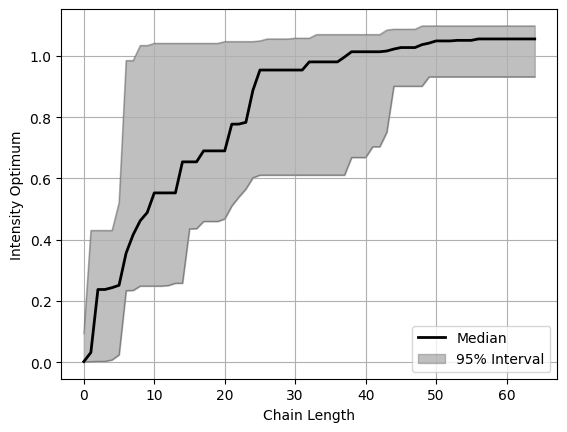

In [ ]:
temp = torch.stack(train_ys)
intens = temp[:,:,0]

hist = intens.numpy()/10.0
temp = []
for i in range(20):
  y1_maxs = np.maximum.accumulate(hist[i,:])
  temp.append(y1_maxs)

t = np.stack(temp)
lower = np.quantile(t, 0.1, axis=0)
upper = np.quantile(t, 0.9, axis=0)
mid = np.quantile(t, 0.5, axis=0)
# means = np.mean(hist, axis=0)
# stds = np.std(hist, axis=0)

# lower = means - stds
# upper = means + stds

plt.plot(lower,'k',linewidth=1, alpha=0.25)
plt.plot(upper, 'k', linewidth=1, alpha=0.25)
plt.plot(mid, 'k', linewidth=2, label="Median")
plt.fill_between(np.arange(65), upper, lower, alpha=0.5, color='gray', label="95% Interval")
plt.xlabel("Chain Length")
plt.ylabel("Intensity Optimum")
plt.grid()
plt.legend()

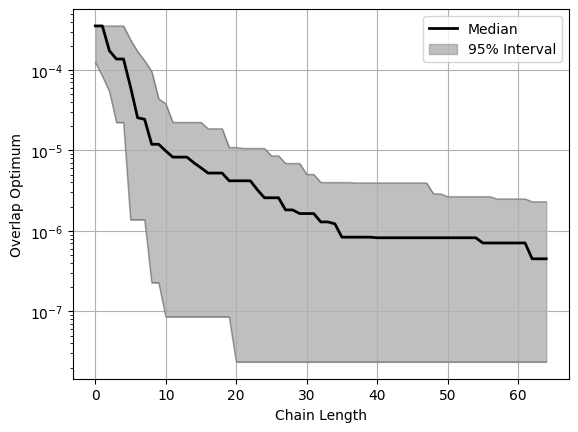

In [ ]:
temp = torch.stack(train_ys)
intens = temp[:,:,1]

hist = intens.numpy()

temp = []
for i in range(20):
  y1_maxs = np.maximum.accumulate(hist[i,:])
  temp.append(y1_maxs)

t = np.stack(temp)
lower = np.quantile(t, 0.1, axis=0)
upper = np.quantile(t, 0.9, axis=0)
mid = np.quantile(t, 0.5, axis=0)
# means = np.mean(hist, axis=0)
# stds = np.std(hist, axis=0)

# lower = means - stds
# upper = means + stds
# ax1.plot(np.exp(-y2_maxs),'k')
# ax1.set_yscale('log')
l = np.exp(-lower)
u = np.exp(-upper)
medianx = np.exp(-mid)

plt.plot(l,'k',linewidth=1, alpha=0.25)
plt.plot(u, 'k', linewidth=1, alpha=0.25)
plt.plot(medianx, 'k', linewidth=2, label="Median")
plt.fill_between(np.arange(65), u, l, alpha=0.5, color='gray', label="95% Interval")
plt.yscale("log")
plt.xlabel("Chain Length")
plt.ylabel("Overlap Optimum")
plt.grid()
plt.legend()